# Projet Kit Big Data MDI 721
Pierre Dal Bianco

## Importation des librairies

In [1]:
# we imort our librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import requests
import os
import re
from bs4 import BeautifulSoup
import datetime
import locale

from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing, cluster
from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import plotly.express as px
from ipyleaflet import Map, Polyline, LegendControl

## Récupération des fichiers Excel avec les classements

Tout d'abord téléchargeons l'ensemble des fichiers sur notre machine, dans un dossier data. Nous pouvons remarquer que le fromat du fichier change une fois que le premier équipage arrive. Nous allons récupérer l'heure et la date d'arrivée du premier équipage pour ne filtrer que les fichiers antérieurs à la date d'arrivée du premier équipage

**Attention :** une fois les fichiers téléchargés il n'est plus nécessaire de ré-executer cette cellule. La dernière ligne ```open...``` a été commentée pour éviter de télécharger les fichiers en cas d'execution par inattention.

In [2]:
# we request the url
req = requests.get('https://www.vendeeglobe.org/fr/classement')

# we raise an Exception if the status code is not 200
if req.status_code != 200:
    raise Exception('Couldn\'t get open URL')

# we get our soup from the downloaded content
soup = BeautifulSoup(req.content)

dates = []
# we extract the arrival dates from the website
for td in soup.find('table', attrs={'class': 'ranking-report'}).findAll('td', attrs={'class': 'row-layout', 'colspan': '2'}):
    dates.append(datetime.datetime.strptime(td.text, 'Date arrivée : %d/%m/%Y %H:%M:%S'))

# we extract the first arrival
first = min(dates)
# we extract the available values from the website's list
for option in soup.find('select', attrs={'class': 'form__input m--select onsubmit-rank'}).findAll('option'):
    date = option.attrs['value']
    # we skip if the date is empty or after the first arrival
    if date != '' and datetime.datetime.strptime(date, '%Y%m%d_%H%M%S') < first:
        file = requests.get('https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+date+'.xlsx')
        #open('data/'+date+'.xlsx', 'wb').write(file.content)

On constate que le premier et le dernier fichier ont des formats différents, nous allons les exclure par la suite. Nous allons créer une fonction pour charger un fichier en dataframe, le nettoyer (supprimer les NA) et convertir toutes ses colonnes en format ad hoc. Nous allons de plus utiliser la colonne 'Hour FR' comme index ```datetime```. 

In [3]:
# we get the list of the files we downloaded
# we remove the .files, which are temporary files created by Excel when we open a file,
# we also exclude the first and the last file
files = [f for f in os.listdir('data/') if not f.startswith('.')][1:-1]

# we load a file
def load_data(filename):
    df = pd.read_excel('data/'+filename, usecols='B:U', skiprows=[0,1,2,3],
                    names=['Rank', 'Nat. Sail', 'Skipper/crew', 'Hour FR', 'Latitude', 'Longitude',
                    'Heading ° 30min', 'Speed kts 30min', 'VMG kts 30min', 'Distance nm 30min',
                    'Heading ° last report', 'Speed kts last report', 'VMG kts last report','Distance nm last report',
                    'Heading ° 24h', 'Speed kts 24h', 'VMG kts 24h', 'Distance nm 24h', 'DTF', 'DTL'])

    # we drop the na values
    df = df.dropna()

    # we split the string values into separate columns
    df['Nationality'] = df['Nat. Sail'].str.split(' ').str[0].str.replace('\n', '')
    df['Sail'] = df['Nat. Sail'].str.split(' ').str[1].apply(int)
    df = df.drop('Nat. Sail', axis=1)

    df['Skipper'] = df['Skipper/crew'].str.split('\n').str[0]
    df['Crew'] = df['Skipper/crew'].str.split('\n').str[1].str.title()
    df = df.drop('Skipper/crew', axis=1)
    
    # we convert the latitude and longitude into decimal
    # Decimal degrees = Degrees + (Minutes/60) + (Seconds/3600), N & E = + /  S & W = - 
    df['Latitude'] = df['Latitude'].apply(lambda s: (1 if s.split('°')[1].split('.')[1][-1] == 'N' else -1)
                                                    * (int(s.split('°')[0])
                                                    + int(s.split('°')[1].split('.')[0])/60
                                                    + int(re.sub('[^0-9]', '', s.split('°')[1].split('.')[1]))/3600))
    df['Longitude'] = df['Longitude'].apply(lambda s: (1 if s.split('°')[1].split('.')[1][-1] == 'E' else -1)
                                                    * (int(s.split('°')[0])
                                                    + int(s.split('°')[1].split('.')[0])/60
                                                    + int(re.sub('[^0-9]', '', s.split('°')[1].split('.')[1]))/3600))

    # we convert the time into a proper datetime value
    date = re.search('([0-9]{8})', filename).group(0)
    df['Hour FR'] = df['Hour FR'].apply(lambda x: datetime.datetime.strptime(date+'_'+x[:5], '%Y%m%d_%H:%M'))

    # we set it as the index
    df = df.set_index('Hour FR')

    # we convert all the numerical values into floats
    df['Rank'] = df['Rank'].apply(int)
    numerical_cols = ['Heading ° 30min', 'Speed kts 30min', 'VMG kts 30min', 'Distance nm 30min',
                    'Heading ° last report', 'Speed kts last report', 'VMG kts last report','Distance nm last report',
                    'Heading ° 24h', 'Speed kts 24h', 'VMG kts 24h', 'Distance nm 24h', 'DTF', 'DTL']
    df[numerical_cols] = df[numerical_cols].apply(lambda x: x.str.replace(re.compile('[a-z]+|°'), '')).apply(pd.to_numeric)

    # we reorder the columns
    df = df[['Rank', 'Nationality', 'Sail', 'Skipper', 'Crew', 'Latitude', 'Longitude', *numerical_cols]]

    return df

# For example let's read the first file
df = load_data(files[1])
df.head()

Rank Nationality  Sail         Skipper  \
Hour FR                                                       
2020-11-08 17:00:00     1         FRA     8   Jérémie Beyou   
2020-11-08 17:00:00     2         FRA    79   Charlie Dalin   
2020-11-08 17:00:00     3         GBR    99    Alex Thomson   
2020-11-08 17:00:00     4         FRA    59   Thomas Ruyant   
2020-11-08 17:00:00     5         MON    10  Boris Herrmann   

                                                   Crew   Latitude  Longitude  \
Hour FR                                                                         
2020-11-08 17:00:00                              Charal  46.353333  -2.597222   
2020-11-08 17:00:00                              Apivia  46.296111  -2.529167   
2020-11-08 17:00:00                           Hugo Boss  46.318889  -2.535000   
2020-11-08 17:00:00                           Linkedout  46.329167  -2.541389   
2020-11-08 17:00:00  Seaexplorer - Yacht Club De Monaco  46.306111  -2.500833   

                     Heading ° 30min  Speed kts 30min  VMG kts 30min  ...  \
Hour FR                                                               ...   
2020-11-08 17:00:00              268             26.0           22.6  ...   
2020-11-08 17:00:00              262             24.8           22.8  ...   
2020-11-08 17:00:00              263             22.8           20.8  ...   
2020-11-08 17:00:00              266             24.3           21.6  ...   
2020-11-08 17:00:00              263             23.9           21.9  ...   

                     Heading ° last report  Speed kts last report  \
Hour FR                                                             
2020-11-08 17:00:00                    262                   21.1   
2020-11-08 17:00:00                    357                    0.0   
2020-11-08 17:00:00                    257                   19.9   
2020-11-08 17:00:00                    260                   19.9   
2020-11-08 17:00:00                    257                   19.0   

                     VMG kts last report  Distance nm last report  \
Hour FR                                                             
2020-11-08 17:00:00                 19.7                     31.7   
2020-11-08 17:00:00                  0.0                   2782.5   
2020-11-08 17:00:00                 19.1                     29.9   
2020-11-08 17:00:00                 18.9                     29.9   
2020-11-08 17:00:00                 18.2                     28.2   

                     Heading ° 24h  Speed kts 24h  VMG kts 24h  \
Hour FR                                                          
2020-11-08 17:00:00            254            1.4          1.4   
2020-11-08 17:00:00            247            1.4          1.4   
2020-11-08 17:00:00            249            1.4          1.3   
2020-11-08 17:00:00            251            1.4          1.3   
2020-11-08 17:00:00            248            1.3          1.3   

                     Distance nm 24h      DTF  DTL  
Hour FR                                             
2020-11-08 17:00:00             34.5  24265.1  0.0  
2020-11-08 17:00:00             32.9  24265.8  0.7  
2020-11-08 17:00:00             32.7  24266.3  1.2  
2020-11-08 17:00:00             32.7  24266.3  1.2  
2020-11-08 17:00:00             31.5  24267.3  2.2  

[5 rows x 21 columns]

Nous allons maintenant boucler sur tous les fichiers pour tous les charger, les convertir et les fusionner en un seul DataFrame.

In [4]:
df_list = []
for f in files:
    df_list.append(load_data(f))
df_all_rankings = pd.concat(df_list)
df_all_rankings.head()

Rank Nationality  Sail         Skipper  \
Hour FR                                                       
2020-11-08 15:30:00     1         FRA    18    Louis Burton   
2020-11-08 15:31:00     2         MON    10  Boris Herrmann   
2020-11-08 15:30:00     3         FRA     8   Jérémie Beyou   
2020-11-08 15:30:00     4         FRA    59   Thomas Ruyant   
2020-11-08 15:30:00     5         FRA    53    Maxime Sorel   

                                                   Crew   Latitude  Longitude  \
Hour FR                                                                         
2020-11-08 15:30:00                     Bureau Vallée 2  46.412778  -1.846667   
2020-11-08 15:31:00  Seaexplorer - Yacht Club De Monaco  46.409444  -1.839444   
2020-11-08 15:30:00                              Charal  46.425278  -1.844167   
2020-11-08 15:30:00                           Linkedout  46.419722  -1.835556   
2020-11-08 15:30:00                     V And B Mayenne  46.416389  -1.832222   

                     Heading ° 30min  Speed kts 30min  VMG kts 30min  ...  \
Hour FR                                                               ...   
2020-11-08 15:30:00              241             17.7           17.5  ...   
2020-11-08 15:31:00              241             11.1           10.9  ...   
2020-11-08 15:30:00              244             15.5           15.5  ...   
2020-11-08 15:30:00              244             13.2           13.1  ...   
2020-11-08 15:30:00              246             10.9           10.9  ...   

                     Heading ° last report  Speed kts last report  \
Hour FR                                                             
2020-11-08 15:30:00                    357                    0.0   
2020-11-08 15:31:00                    357                    0.0   
2020-11-08 15:30:00                    357                    0.0   
2020-11-08 15:30:00                    357                    0.0   
2020-11-08 15:30:00                    357                    0.0   

                     VMG kts last report  Distance nm last report  \
Hour FR                                                             
2020-11-08 15:30:00                  0.0                   2788.0   
2020-11-08 15:31:00                  0.0                   2787.9   
2020-11-08 15:30:00                  0.0                   2788.5   
2020-11-08 15:30:00                  0.0                   2788.3   
2020-11-08 15:30:00                  0.0                   2788.1   

                     Heading ° 24h  Speed kts 24h  VMG kts 24h  \
Hour FR                                                          
2020-11-08 15:30:00            201            0.3          0.3   
2020-11-08 15:31:00            196            0.3          0.2   
2020-11-08 15:30:00            199            0.2          0.2   
2020-11-08 15:30:00            196            0.2          0.2   
2020-11-08 15:30:00            195            0.8          0.7   

                     Distance nm 24h      DTF  DTL  
Hour FR                                             
2020-11-08 15:30:00              6.1  24293.9  0.0  
2020-11-08 15:31:00              6.0  24294.2  0.4  
2020-11-08 15:30:00              5.5  24294.3  0.5  
2020-11-08 15:30:00              5.6  24294.5  0.6  
2020-11-08 15:30:00              5.8  24294.5  0.6  

[5 rows x 21 columns]

On peut exporter le DataFrame au format pickle pour pouvoir le charger facilement plus tard.

In [5]:
# we save the dataframe
df_all_rankings.to_pickle('df_all_rankings.pkl')

In [6]:
# we import it
df_all_rankings = pd.read_pickle('df_all_rankings.pkl')

## Première exploration des données

Nous allons extraire quelques informations de notre jeu de données pour en apprendre plus sur la course et ses participants (ceux qui ont fini la course).

De combien de lignes de données disposons nous ?

In [7]:
df_all_rankings.shape

(13703, 21)

Quels sont les équipages, le nom et numéro de leur bateau, leur nationalité ainsi que la distance moyenne parcourue par tranche de 24h ?

In [8]:
df_all_rankings.groupby(['Sail', 'Nationality', 'Skipper', 'Crew'])['Distance nm 24h'].mean().sort_values(ascending=False)

Sail  Nationality  Skipper               Crew                                  
79    FRA          Charlie Dalin         Apivia                                    331.893971
59    FRA          Thomas Ruyant         Linkedout                                 330.590249
18    FRA          Louis Burton          Bureau Vallée 2                           330.461411
10    MON          Boris Herrmann        Seaexplorer - Yacht Club De Monaco        328.065353
85    FRA          Kevin Escoffier       Prb                                       327.411679
17    FRA          Yannick Bestaven      Maître Coq Iv                             327.220332
34    ITA          Giancarlo Pedote      Prysmian Group                            324.185062
9     FRA          Benjamin Dutreux      Omia - Water Family                       320.427386
1000  FRA          Damien Seguin         Groupe Apicil                             320.201660
1     FRA          Jean Le Cam           Yes We Cam !                     

Quel est le classement moyen de chaque équipage ?

In [9]:
df_all_rankings.groupby(['Nationality', 'Skipper', 'Crew'])['Rank'].mean().sort_values()

Nationality  Skipper               Crew                                  
FRA          Charlie Dalin         Apivia                                     2.286902
             Thomas Ruyant         Linkedout                                  3.520747
             Yannick Bestaven      Maître Coq Iv                              4.373444
             Jean Le Cam           Yes We Cam !                               5.599585
             Kevin Escoffier       Prb                                        5.846715
             Damien Seguin         Groupe Apicil                              6.383817
             Louis Burton          Bureau Vallée 2                            6.819502
MON          Boris Herrmann        Seaexplorer - Yacht Club De Monaco         6.939834
FRA          Nicolas Troussel      Corum L'Épargne                            7.260000
GBR          Alex Thomson          Hugo Boss                                  7.461538
FRA          Benjamin Dutreux      Omia - Water Family  

Combien de temps a durée la course ? Nous n'avons les données que jusqu'à ce que le premier équipage arrive, on peut s'attendre à une durée légerement inférieure à celle annoncée sur le site internet (80j).

In [10]:
df_all_rankings.index.max()-df_all_rankings.index.min()

Timedelta('79 days 23:05:00')

Essayons maintenant de faire quelques tracés pour mieux comprendre notre jeu de données. Nous allons tirer 4 skippers aléatoires et tracer les vitesses, VMG et distance sur les dernières 24h.

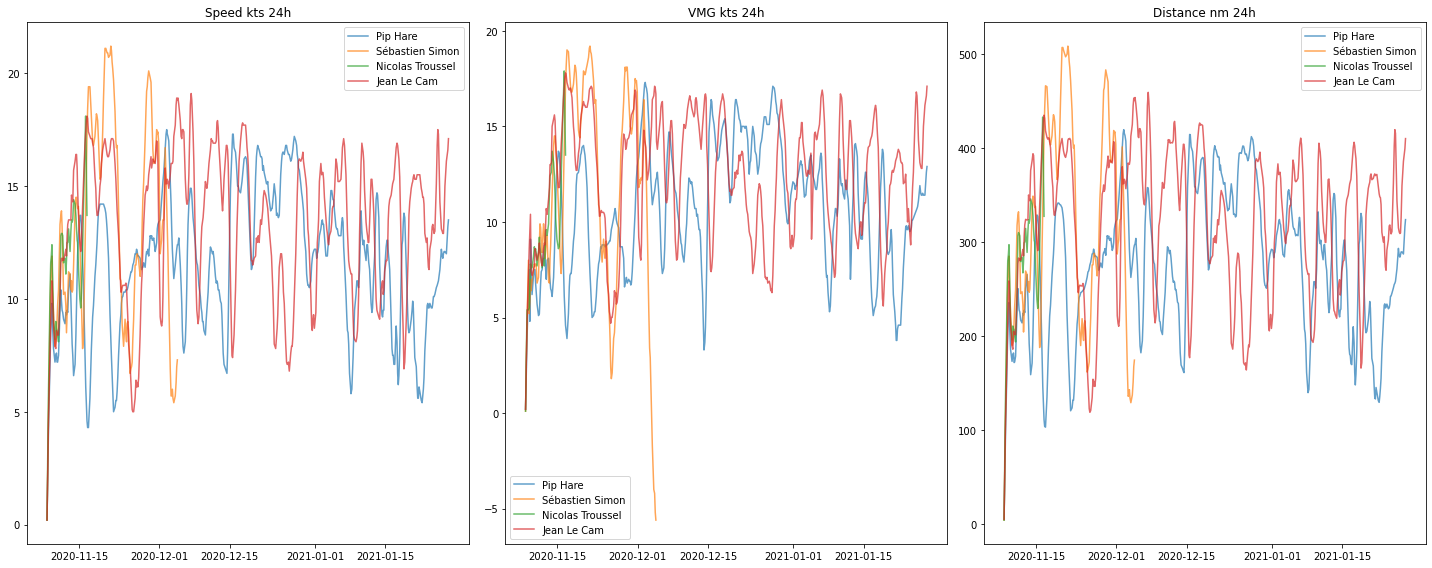

In [11]:
# we prepare our plot
fig = plt.figure(figsize=(20, 8));
k = 1

# we pick 4 rndom skippers
skippers = np.random.choice(df_all_rankings['Skipper'].unique(), 4)
columns_graph = ['Speed kts 24h', 'VMG kts 24h', 'Distance nm 24h']

# for each column
for col in columns_graph:
    # we add a subplot
    ax = fig.add_subplot(1, 3, k)
    # we plot the categories in each subplot
    for sk in skippers:
        ax.plot(df_all_rankings[df_all_rankings['Skipper'] == sk].index,
                df_all_rankings.loc[df_all_rankings['Skipper'] == sk, col],
                label = sk, alpha=0.7);
        ax.set_title(col);
    ax.legend();
    k+=1
fig.tight_layout()

Quel est l'équipage qui finit premier lors du dernier jour avant la fin de la course

In [12]:
crew_first_last = df_all_rankings.loc[(df_all_rankings['Rank'] == 1) & (df_all_rankings.index == df_all_rankings[df_all_rankings['Rank'] == 1].index.max()), 'Crew'].values[0]
crew_first_last

'Apivia'

Pouvons-nous voir un lien entre le classement et la VMG sur 24h pour l'équipage que nous venons d'isoler ?

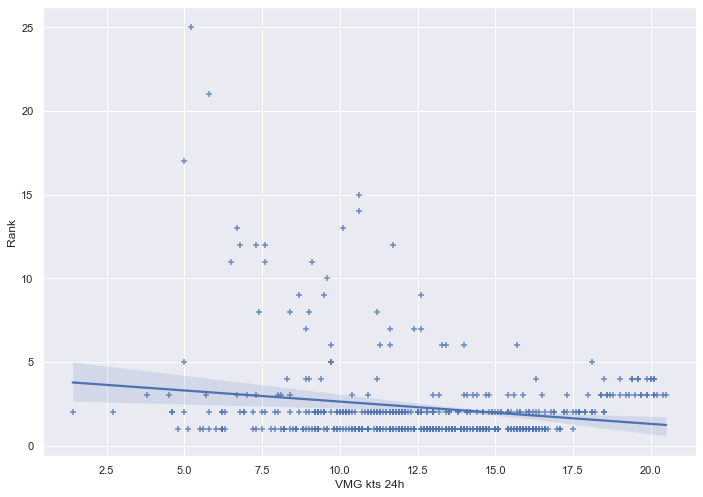

In [13]:
# we get the average 24h VMG and Distance for the crew we just isolated
VMG_24_APIVIA = df_all_rankings.loc[df_all_rankings['Crew'] == crew_first_last, ('VMG kts 24h', 'Rank')]

# we graph its regression using Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.regplot(x='VMG kts 24h', y='Rank', data=VMG_24_APIVIA,  marker="+");

Le lien n'est pas immédiatement évident 'à l'oeil nu'.

## Corrélation et régression linéaire

Faisons une regression linéaire entre le classement et la vitesse utile (VMG).

D'abord nous allons retirer les valeurs négatives de la VMG sur 24h, qui peuvent être vues comme des outliers. Nous allons ensuite splitter les données pour créer un jeu de train (constitué de 75% des données initiales) et un jeu de test (25% des données initiales). Puis nous allons faire une régression linéraire des moindres carrés.

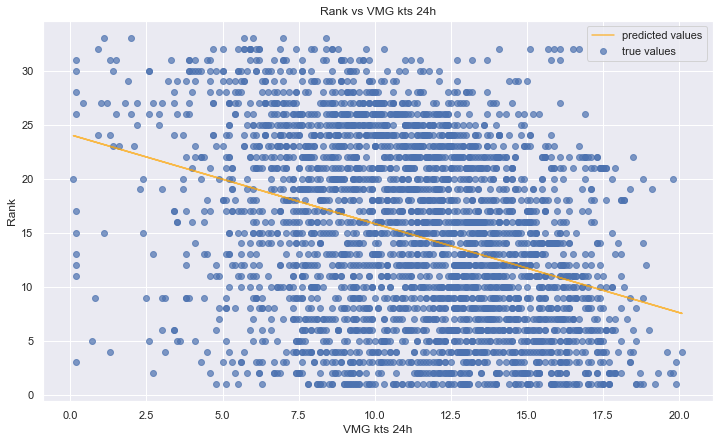

In [14]:
# we define our variables x and y_true for our regression
# we are removing lines with negative VMG
x = df_all_rankings.loc[df_all_rankings['VMG kts 24h']>0, ['VMG kts 24h']].values.reshape(-1, 1)
y_true = df_all_rankings.loc[df_all_rankings['VMG kts 24h']>0, ['Rank']].values

# we split the dataset to create a train and a test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y_true, test_size=0.25)

# we perform the linear regression using sklearn
linmod = linear_model.LinearRegression()
linmod.fit(x_train, y_train)

y_pred = linmod.predict(x_test)

# we plot the graph
fig = plt.figure(figsize=(12, 7));
ax = fig.add_subplot()
ax.scatter(x=x_test, y=y_test, alpha=0.7, label='true values')
ax.plot(x_test, y_pred, color='orange', alpha=0.7, label='predicted values')

ax.set_xlabel('VMG kts 24h');
ax.set_ylabel('Rank');
ax.set_title('Rank vs VMG kts 24h');
ax.legend();

Pour évaluer notre régression on peut calculer et afficher l'erreur quadratique (doit être le plus faible possible) et le coefficient de détermination (doit être le plus proche de 1 possible).

In [15]:
# we calculate the prediction error
risk_square_OLS= mean_squared_error(y_test, y_pred)

# we calculate the R2 score
R_square_OLS = r2_score(y_test, y_pred)

print('Le coefficient de détermination est de R²={:.2f}'.format(R_square_OLS))
print('Le risque de prediction est de Rpred={:.2f}'.format(risk_square_OLS))

Le coefficient de détermination est de R²=0.12
Le risque de prediction est de Rpred=61.76


On peut également tracer la densité des résidus = vraies valeurs - valeurs prédites

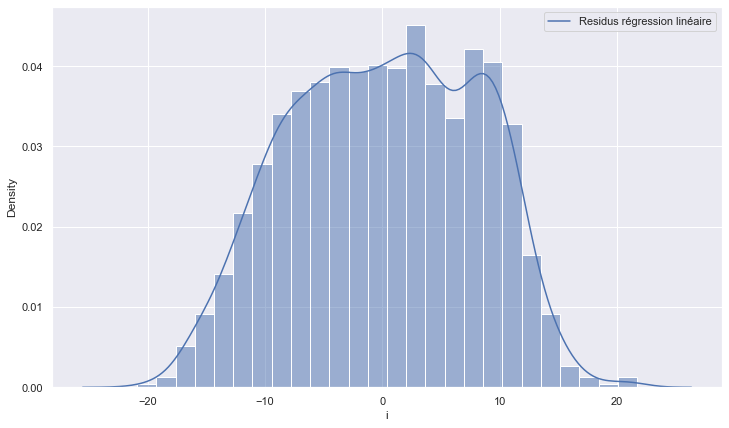

In [16]:
r = y_test - y_pred
# modify the size of the seaborn plot
sns.set(rc={'figure.figsize':(12,7)})

# we plot the residus
sns.kdeplot(r.reshape(-1,), label='Residus régression linéaire');

# we add a histogram
sns.histplot(r.reshape(-1,), stat='density', alpha=0.5);
plt.xlabel('i')
plt.legend();

Pour aller plus loin, on pourrait essayer d'identifier d'autres facteurs qui pourraient influencer le classement pour faire une régression linéaire sur plusieurs variables explicatives. La fonction pairplot de Seaborn est un bon point de départ pour cela.

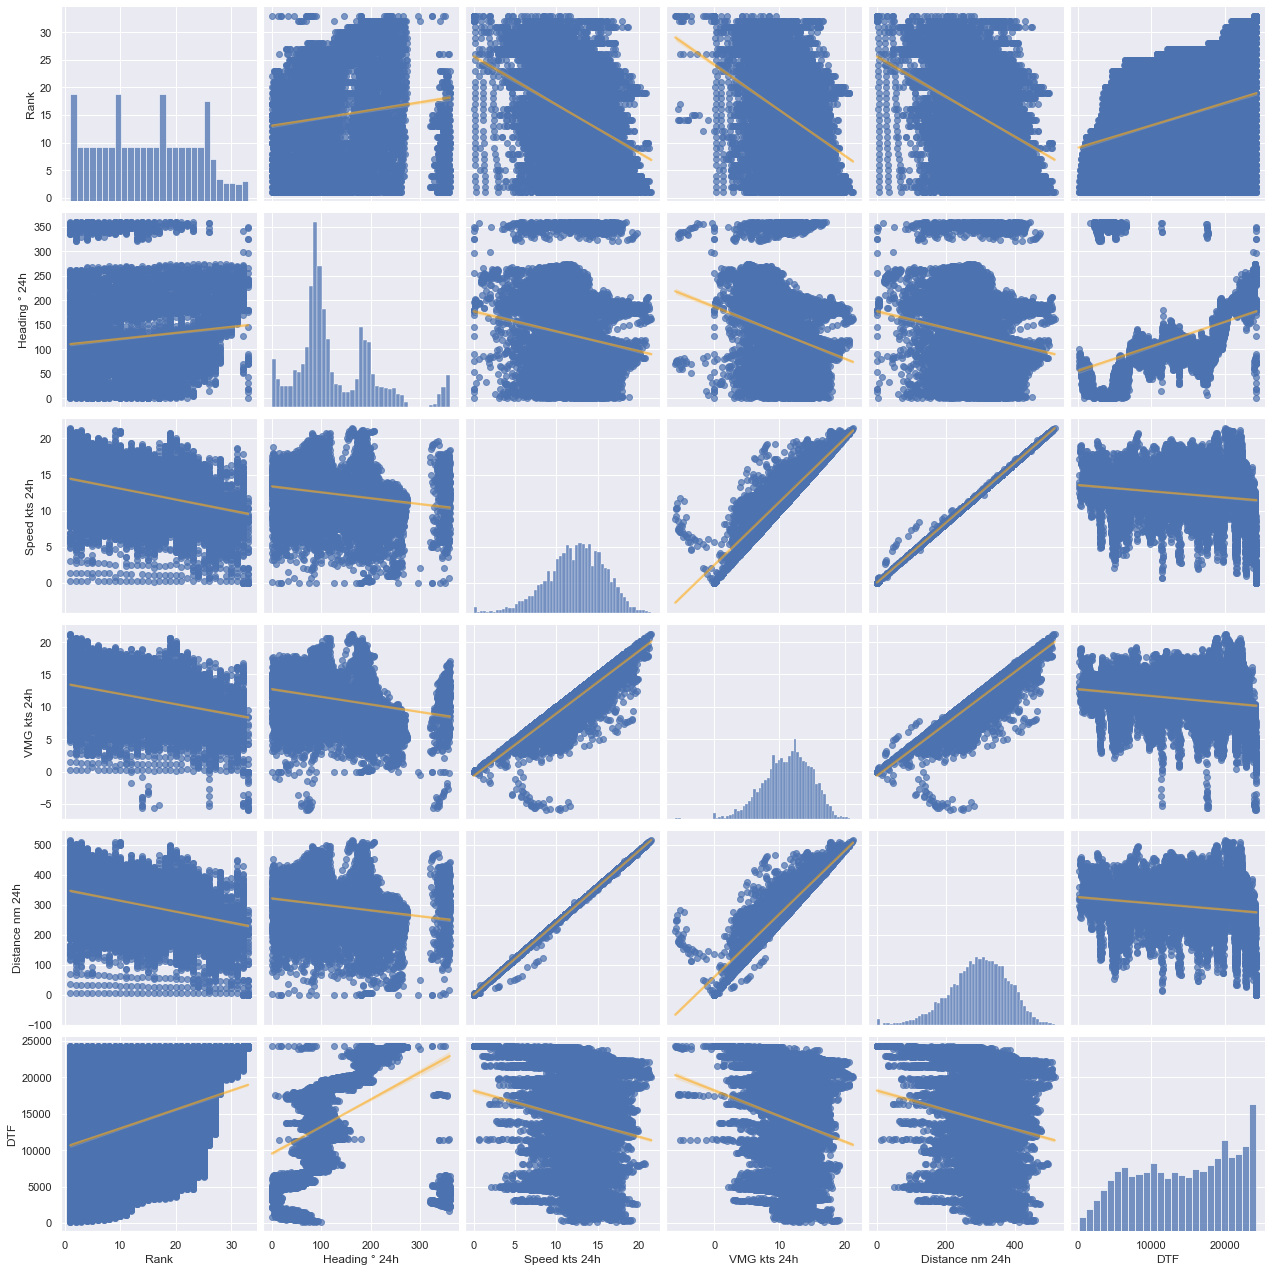

In [17]:
# tracé pairplot avec Seaborn
sns.pairplot(df_all_rankings[['Rank', 'Heading ° 24h', 'Speed kts 24h', 'VMG kts 24h', 'Distance nm 24h', 'DTF']].reset_index(),
             height=3,
             kind='reg', 
             plot_kws={'line_kws':{'color':'orange', 'alpha':0.5}, 'scatter_kws': {'alpha': 0.7}});

Grâce à ce pairplot on se rend compte que qu'il semble avoir une relation linéaire entre les variables distance, VMG et Speed. Faisons une régression linéaire du rang en fonction de ces vaibles ainsi que la variable DTF et comparons les scores obtenus avec ceux de notre régression précedente.

In [18]:
# we define our variables x and y_true for our regression
# we are removing lines with negative columns
cols_regression = ['Speed kts 24h', 'VMG kts 24h', 'Distance nm 24h', 'DTF']
x = df_all_rankings.loc[(df_all_rankings[cols_regression] > 0).all(axis=1), cols_regression]
y_true = df_all_rankings.loc[(df_all_rankings[cols_regression] > 0).all(axis=1), ['Rank']].values

# we split the dataset to create a train and a test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y_true, test_size=0.25)

# we perform the linear regression using sklearn
linmod = linear_model.LinearRegression()
linmod.fit(x_train, y_train)

y_pred = linmod.predict(x_test)

# we calculate the prediction error
risk_square_OLS_multivar = mean_squared_error(y_test, y_pred)

# we calculate the R2 score
R_square_OLS_multivar = r2_score(y_test, y_pred)

print('Le coefficient de détermination est de R²={:.2f}'.format(R_square_OLS_multivar))
print('Le risque de prediction est de Rpred={:.2f}'.format(risk_square_OLS_multivar))

Le coefficient de détermination est de R²=0.21
Le risque de prediction est de Rpred=57.02


On obtient des scores un peu meilleurs avec cette régression.

## Extraction des données sur les voiliers

Nous allons extraire toutes les données sur les bateaux sous forme d'un DataFrame que nous allons ensuite nettoyer pour obtenir des données sous forme exploitable

In [19]:
# we request the url
headers = {'User-Agent' : 'Mozilla/5.0'}
req_skip = requests.get('https://www.vendeeglobe.org/fr/glossaire', headers = headers)

# we raise an Exception if the status code is not 200
if req_skip.status_code != 200:
    raise Exception('Couldn\'t get open URL')

# we get our soup from the downloaded content
soup_skip = BeautifulSoup(req_skip.content)

# we extract the arrival dates from the website
df_list = []
for div in soup_skip.findAll('div', attrs={'class': 'boats-list__popup-infos'}):
    # we get the skipper name
    skip_name = div.find('h3', attrs={'class': 'boats-list__popup-title'}).text.title()
    skippers_info = {'Equipage':skip_name}
    # we get the rest of the data
    for li in div.find('ul', attrs={'class': 'boats-list__popup-specs-list'}).findAll('li'):
        info = li.text.split(' : ')
        skippers_info[info[0].strip()] = [info[1].strip()]

    # we append all data as dataframes
    df_list.append(pd.DataFrame(skippers_info))

# we generate a dataframe containing all of the extracted data
df_skippers = pd.concat(df_list, ignore_index=True)

df_skippers.head()

# we replace the former names of the boat by a propoer list of strings
df_skippers['Anciens noms du bateau'] = df_skippers['Anciens noms du bateau'].fillna('').str.strip().str.split(',')

# we convert all numerical value into floats or int
numerical_cols = ['Longueur', 'Largeur', 'Tirant d\'eau', 'Déplacement (poids)','Hauteur mât','Surface de voiles au près','Surface de voiles au portant']
df_skippers[numerical_cols] = df_skippers[numerical_cols].apply(lambda x: x.str.replace(re.compile('m2|m²|m|t[a-z]*|nc|NC'), '').str.replace(',', '.')).apply(pd.to_numeric)

# we rename the columns to include the units
df_skippers = df_skippers.rename(columns={'Longueur': 'Longueur (m)', 'Largeur': 'Largeur (m)', 'Tirant d\'eau': 'Tirant d\'eau (m)', 'Déplacement (poids)': 'Déplacement (poids) (t)','Hauteur mât': 'Hauteur mât (m)','Surface de voiles au près': 'Surface de voiles au près (m2)', 'Surface de voiles au portant': 'Surface de voiles au portant (m2)'})

# we correct the 'foiler' vs 'foils' categories
df_skippers['Nombre de dérives'] = df_skippers['Nombre de dérives'].str.replace('foiler', 'foils')

# we convert all dates into datetimes
locale.setlocale(locale.LC_ALL, 'fr')
df_skippers['Date de lancement'] = df_skippers['Date de lancement'].apply(lambda x: datetime.datetime.strptime(x, '%d %B %Y'))

df_skippers.head()

Equipage Numéro de voile  \
0  Newrest - Art & Fenêtres          FRA 56   
1      Pure - Best Western®          FRA 49   
2          Tse -  4Myplanet           FRA72   
3             Maître Coq Iv              17   
4                    Charal              08   

                              Anciens noms du bateau         Architecte  \
0                  [No Way Back,  Vento di Sardegna]       VPLP/Verdier   
1       [Gitana Eighty,  Synerciel,  Newrest-Matmut]  Bruce Farr Design   
2  [Famille Mary-Etamine du Lys,  Initiatives Coe...       Marc Lombard   
3                    [Safran 2 - Des Voiles et Vous]     Verdier - VPLP   
4                                                 []               VPLP   

                                   Chantier Date de lancement  Longueur (m)  \
0                            Persico Marine        2015-08-01         18.28   
1  Southern Ocean Marine (Nouvelle Zélande)        2007-03-08         18.28   
2                                MAG France        1998-03-01         18.28   
3                          CDK Technologies        2015-03-12         18.28   
4                          CDK Technologies        2018-08-18         18.28   

   Largeur (m)  Tirant d'eau (m)  Déplacement (poids) (t) Nombre de dérives  \
0         5.85               4.5                      7.0             foils   
1         5.80               4.5                      9.0                 2   
2         5.54               4.5                      9.0                 2   
3         5.80               4.5                      8.0             foils   
4         5.85               4.5                      8.0             foils   

   Hauteur mât (m)        Voile quille  Surface de voiles au près (m2)  \
0             29.0            monotype                             320   
1             28.0         acier forgé                             280   
2             29.0               acier                             260   
3             29.0  acier mécano soudé                             310   
4             29.0               acier                             320   

   Surface de voiles au portant (m2)  
0                                570  
1                                560  
2                                580  
3                                550  
4                                600

Tout comme le DataFrame précédent on peut exporter celui-ci sous le format pickle pour le charger rapidement plus tard.

In [20]:
# export to pickle
df_skippers.to_pickle('df_skippers.pkl')

In [21]:
# import back in
df_skippers = pd.read_pickle('df_skippers.pkl')

## Rapprochement des données des voiliers avec celle des classements

Nous pouvons insérer les données voilers que nous venons d'extraire dans le premier DataFrame

In [22]:
# we merge the two dataframes
df_ranking_skippers = pd.merge(left=df_all_rankings.reset_index(), right=df_skippers, left_on='Crew', right_on='Equipage', how='inner').set_index('Hour FR')
df_ranking_skippers.sample(5)

Rank Nationality  Sail        Skipper           Crew  \
Hour FR                                                                     
2020-11-14 05:30:00    33         FRA     8  Jérémie Beyou         Charal   
2020-12-26 17:30:00     9         FRA    59  Thomas Ruyant      Linkedout   
2021-01-07 17:30:00     4         FRA  1000  Damien Seguin  Groupe Apicil   
2021-01-20 04:30:00    17         GBR   777       Pip Hare       Medallia   
2020-11-23 08:30:00    12         FRA  1000  Damien Seguin  Groupe Apicil   

                      Latitude   Longitude  Heading ° 30min  Speed kts 30min  \
Hour FR                                                                        
2020-11-14 05:30:00  46.260833   -2.821389               61              8.9   
2020-12-26 17:30:00 -48.786389 -147.922778               30              6.0   
2021-01-07 17:30:00 -45.914167  -42.689444              338             10.9   
2021-01-20 04:30:00 -30.052500  -40.535278               22              8.5   
2020-11-23 08:30:00 -20.328611  -29.220556              187             10.7   

                     VMG kts 30min  ...  Date de lancement  Longueur (m)  \
Hour FR                             ...                                    
2020-11-14 05:30:00           -7.6  ...         2018-08-18         18.28   
2020-12-26 17:30:00           -0.2  ...         2019-09-03         18.28   
2021-01-07 17:30:00            7.6  ...         2008-08-10         18.28   
2021-01-20 04:30:00            8.4  ...         1999-07-03         18.28   
2020-11-23 08:30:00            7.5  ...         2008-08-10         18.28   

                     Largeur (m)  Tirant d'eau (m)  Déplacement (poids) (t)  \
Hour FR                                                                       
2020-11-14 05:30:00         5.85               4.5                      8.0   
2020-12-26 17:30:00         5.85               4.5                      8.0   
2021-01-07 17:30:00         5.85               4.5                      8.5   
2021-01-20 04:30:00         5.70               4.5                      9.0   
2020-11-23 08:30:00         5.85               4.5                      8.5   

                     Nombre de dérives  Hauteur mât (m)  Voile quille  \
Hour FR                                                                 
2020-11-14 05:30:00              foils             29.0         acier   
2020-12-26 17:30:00              foils             29.0   acier forgé   
2021-01-07 17:30:00                  2             29.0   acier forgé   
2021-01-20 04:30:00                  2             29.0       carbone   
2020-11-23 08:30:00                  2             29.0   acier forgé   

                     Surface de voiles au près (m2)  \
Hour FR                                               
2020-11-14 05:30:00                             320   
2020-12-26 17:30:00                             350   
2021-01-07 17:30:00                             350   
2021-01-20 04:30:00                             300   
2020-11-23 08:30:00                             350   

                     Surface de voiles au portant (m2)  
Hour FR                                                 
2020-11-14 05:30:00                                600  
2020-12-26 17:30:00                                560  
2021-01-07 17:30:00                                610  
2021-01-20 04:30:00                                580  
2020-11-23 08:30:00                                610  

[5 rows x 36 columns]

## Impact de la présence d'un *foil*

Calculons les vitesses, VMG et distances moyennes sur 24h et le nombre d'équipages par type de dérive

In [23]:
# we agregate some numerical values by Type of foil
df_ranking_skippers.groupby(['Nombre de dérives']).agg({'Crew': lambda x: x.nunique(),
                                                        'Speed kts 24h': np.mean,
                                                        'VMG kts 24h': np.mean,
                                                        'Distance nm 24h': np.mean})

Crew  Speed kts 24h  VMG kts 24h  Distance nm 24h
Nombre de dérives                                                   
2                     7      11.406769    10.446086       273.599728
2 asymétriques        1      11.388589    10.174689       273.325934
foils                15      12.936539    11.762465       310.441616

Il semble qu'en moyenne sur 24h les voiliers équipés de foils ont une plus grand vitesse, VMG et parcourent une plus grande distance. La présence d'un foil semble donc apporter un bénefice.

Seaborn permet de tracer des barplot des distances sur 24h et de les grouper par le nombre de dérives.

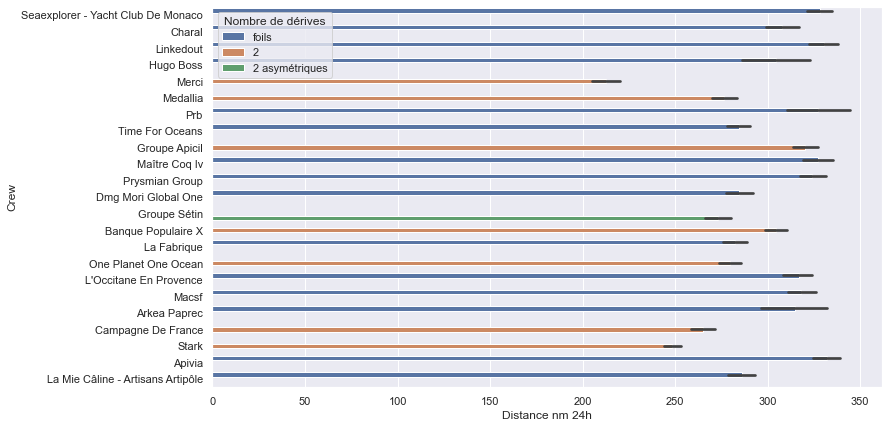

In [24]:
sns.barplot(data=df_ranking_skippers, y='Crew', x='Distance nm 24h', hue='Nombre de dérives', orient='h');

En complément nous pouvons tracer moyennes sur 24h des vitesses, VMG et distances par type de dérive. Nous allons faire un resample par moyenne par jour pour afficher des résultats lisibles.

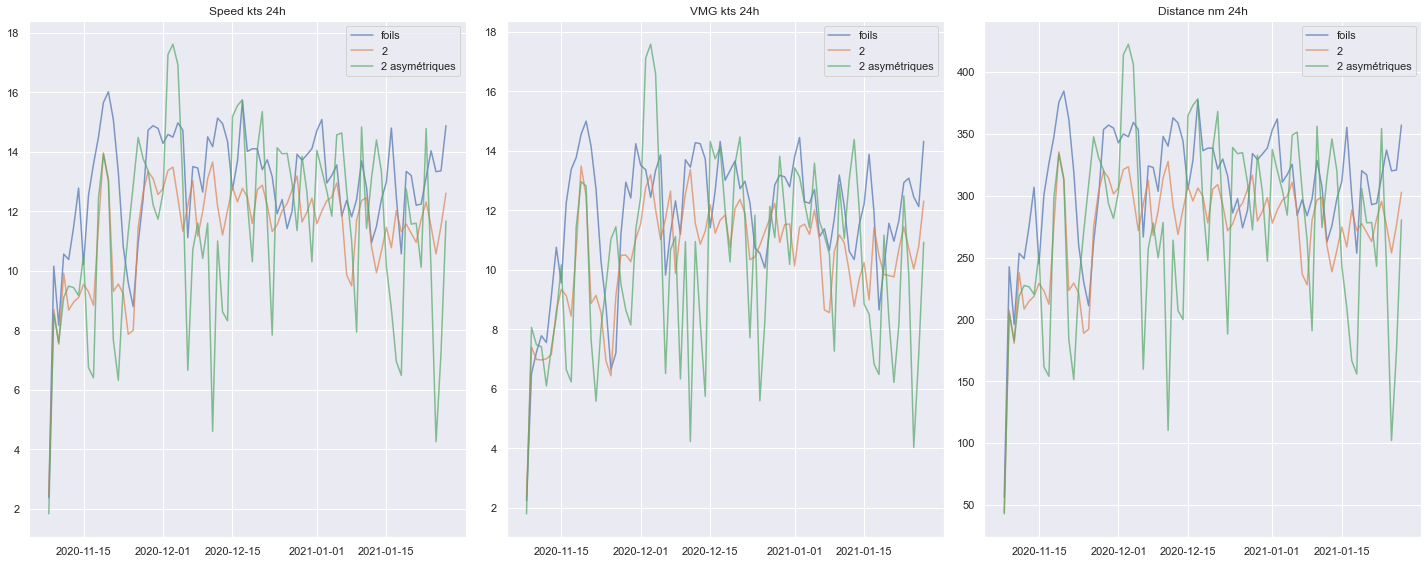

In [25]:
# we prepare our plot
fig = plt.figure(figsize=(20, 8));
k = 1

# we extract the 4 different types of foils
types = df_ranking_skippers['Nombre de dérives'].unique()
columns_graph = ['Speed kts 24h', 'VMG kts 24h', 'Distance nm 24h']

# for each column
for col in columns_graph:
    # we add a subplot
    ax = fig.add_subplot(1, 3, k)
    # we plot the categories in each subplot
    for t in types:
        ax.plot(df_ranking_skippers[df_ranking_skippers['Nombre de dérives'] == t].resample('D').mean().index,
                df_ranking_skippers.loc[df_ranking_skippers['Nombre de dérives'] == t, col].resample('D').mean(),
                label = t, alpha=0.7);
        ax.set_title(col);
    ax.legend();
    k+=1
fig.tight_layout()

D'après ces graphes il apparaît assez clairement que les voiliers équipés de foils ont des meilleurs résultats (en terme de vitesse, VMG et distance moyennes sur 24h) que ceux équipés de 2 dérives. Le voilier équipé de 2 dérives asymétriques a une variabilité plus importante, et a en moyenne des résultats moins bons que les voiliers équipés de foils, d'après les résultats vus précedemment, mais cela peut aussi être dû au fait qu'il n'y a qu'un seul équipage qui utilise ce type de dérive. Il y a donc moins de données pour moyenner.

Nous pouvons aussi essayer de voir si la présence d'un foil a une influence sur le classement. Avec Seaborn on peut faire une heatmap du classement en fonction des valeurs dans la colonne Nombre de dérives

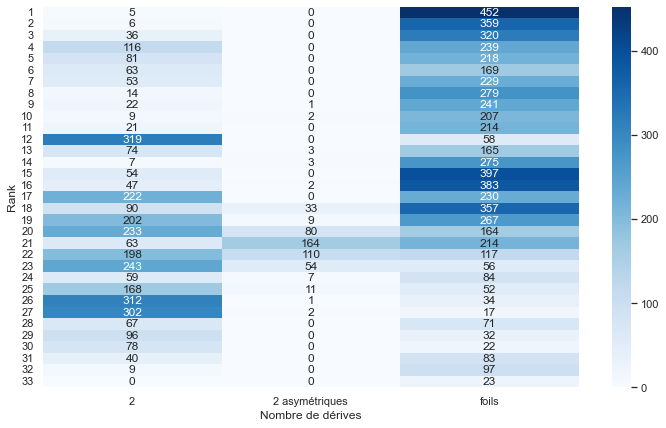

In [26]:
sns.heatmap(pd.crosstab(df_ranking_skippers['Rank'], df_ranking_skippers['Nombre de dérives']), cmap='Blues', annot=True, fmt='d');

Il semblerait que les équipages qui ont un foil arrivent plus souvent en tête de classement, mais il sont aussi plus nombreux, ce qui peut expliquer ce qu'on observe.

## Visualisation de la distance parcourue par voilier

Dans un premier temps on peut tracer les distances (sur 30min, 24h et depuis le dernier rapport) pour 4 voiliers tirés au hasard. Nous allons lisser les résultats sur 1 semaine pour une meilleur lisibilité.

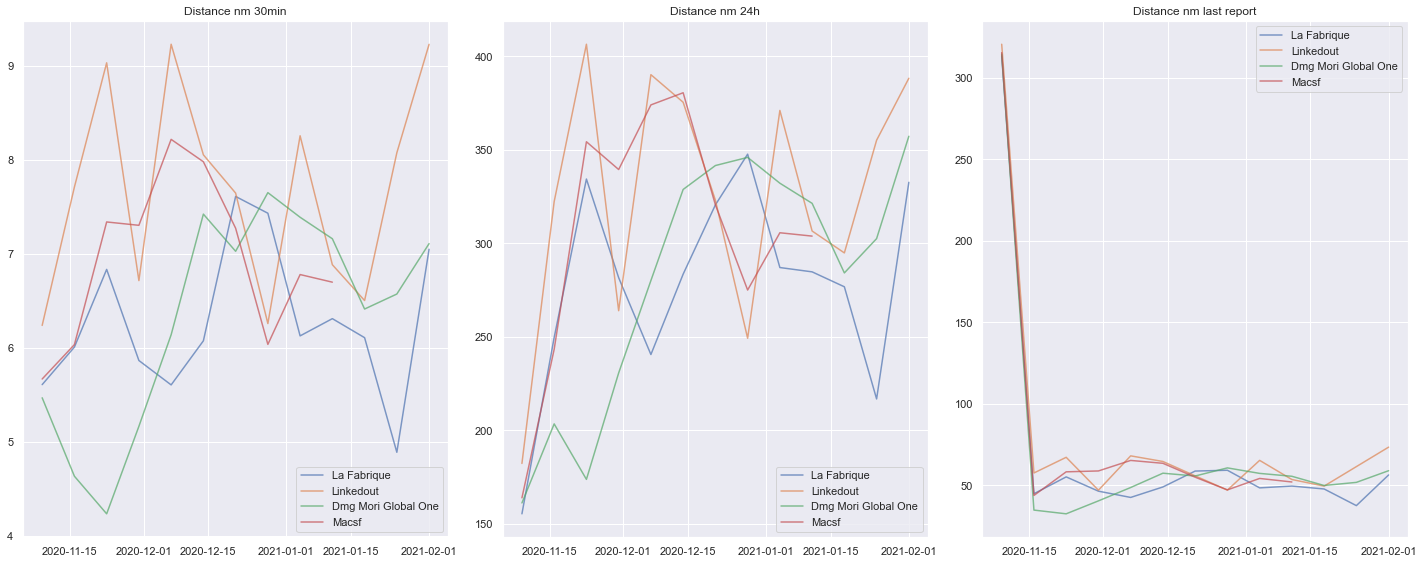

In [27]:
# we prepare our plot
fig = plt.figure(figsize=(20, 8));
k = 1

# we pick 4 random crews
crew = np.random.choice(df_ranking_skippers['Crew'].unique(), 4, replace=False)
columns_graph = ['Distance nm 30min', 'Distance nm 24h', 'Distance nm last report']

# for each column
for col in columns_graph:
    # we add a subplot
    ax = fig.add_subplot(1, 3, k)
    # we plot the categories in each subplot
    for cw in crew:
        ax.plot(df_ranking_skippers[df_ranking_skippers['Crew'] == cw].resample('W-MON').mean().index,
                df_ranking_skippers.loc[df_ranking_skippers['Crew'] == cw, col].resample('W-MON').mean(),
                label = cw, alpha=0.7);
        ax.set_title(col);
    ax.legend();
    k+=1
fig.tight_layout()

Traçons maintenant les distances parcourues par équipage. Nous allons mettre en évidence les équipages qui utilisent des foils.

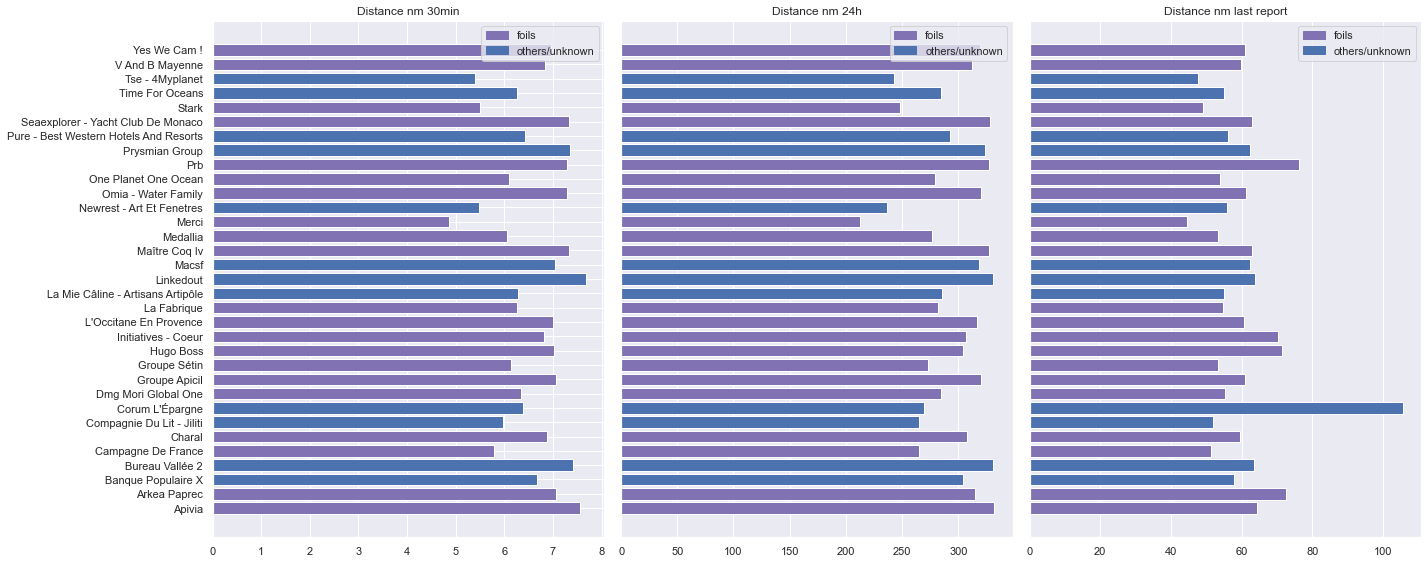

In [28]:
# we prepare our plot
fig = plt.figure(figsize=(20, 8));
k = 1

# we pick 4 random crews
crew = df_all_rankings['Crew'].unique()
columns_graph = ['Distance nm 30min', 'Distance nm 24h', 'Distance nm last report']

# we create an aggregate, that will be useful to generate a colors map
agg_derive = df_ranking_skippers.pivot_table(values='Nombre de dérives', index='Crew', aggfunc='first')
# we generate the colors map
colors = ['m' if nd=='foils' else 'b' for nd in agg_derive.values]

# we create an aggregate for the graph
agg_crew = df_all_rankings.pivot_table(values=columns_graph, index='Crew', aggfunc='mean')

# we generate custom legends
custom_legend = [Patch(color='m', label='foils'),
                Patch(color='b', label='others/unknown')]

# for each column
for col in columns_graph:
    # we add a subplot
    ax = fig.add_subplot(1, 3, k)
    # we plot the columns values in each subplot
    ax.barh(y=agg_crew.index, width=agg_crew[col], color=colors);
    ax.set_title(col);

    # we hide the labels for the other 2 plots
    if k > 1:
        ax.get_yaxis().set_visible(False)
    k+=1
    # we generate and attach the custom legend
    ax.legend(handles=custom_legend)
fig.tight_layout()

## Cartes avec les routes d'un ou plusieurs voiliers

Affichons des cartes avec les routes de plusieurs équipages avec ```ipyleaflet```.

In [30]:
crews = np.random.choice(df_all_rankings['Crew'].unique(), 4)
colors = ['cyan', 'magenta', 'yellow', 'black']
m = Map(center = (0, 0), zoom=2)
legend = LegendControl({cw:cl for cw,cl in zip(crews, colors)}, name="Legend", position="topleft")

m.add_control(legend)

for i, cw in enumerate(crews):
    latitudes = df_all_rankings.loc[df_all_rankings['Crew']==cw, 'Latitude'].values
    longitudes = df_all_rankings.loc[df_all_rankings['Crew']==cw, 'Longitude'].values

    line = Polyline(
        locations=list(zip(latitudes, longitudes)),
        color=colors[i] ,
        opacity=0.5,
        weight=2,
        fill=False
    )
    m.add_layer(line)

m

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Affichons tous les itinéraires avec ```plotly``` sur un globe 3D.

In [31]:
fig = px.line_geo(df_all_rankings, lat='Latitude', lon='Longitude',
                  color="Crew",
                  projection="orthographic")
fig.show()

## Analyses de séries temporelles

Analysons l'évolution de la VMG (sur 24h) moyenne au cours de la course. Dans un premier temps nous allons génerer un dataframe qui agrège l'évolution de la VMG au cours du temps. Nous allons faire une resampling sur 4 hours et remplir les NA avec un forward fill.

In [32]:
df_vmg_average = df_all_rankings.pivot_table(values='VMG kts 24h', index='Hour FR', aggfunc='mean').resample('4H').mean().fillna(method='ffill')
df_vmg_average.head()

VMG kts 24h
Hour FR                         
2020-11-08 12:00:00     0.186111
2020-11-08 16:00:00     2.029688
2020-11-08 20:00:00     4.818182
2020-11-09 00:00:00     4.818182
2020-11-09 04:00:00     6.709091

Ajoutons une moyenne glissante sur 5 jours et traçons les résultats

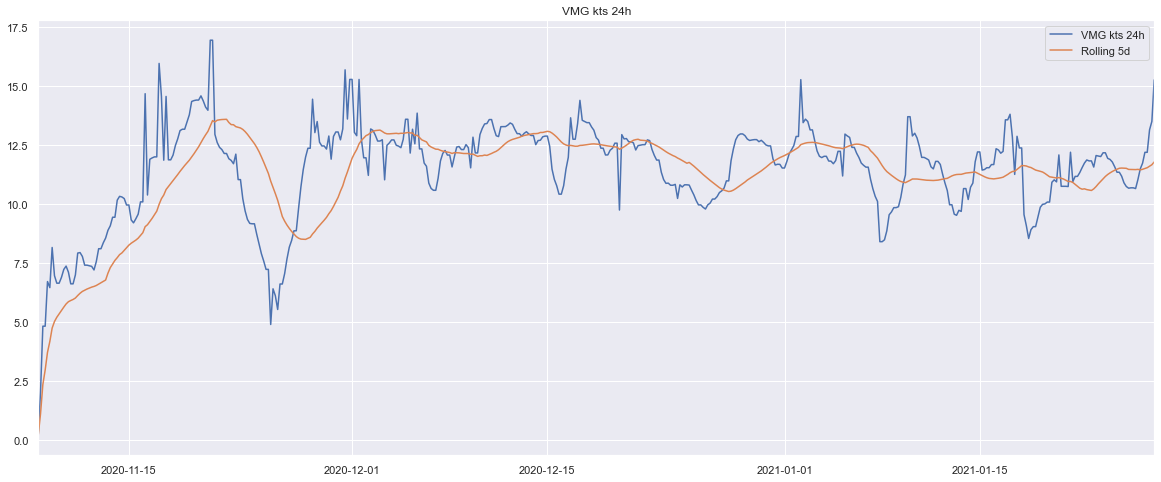

In [33]:
df_vmg_average['Rolling 5d'] = df_vmg_average['VMG kts 24h'].rolling('5d').mean()

fig = plt.figure(figsize=(20, 8));
ax = fig.add_subplot(111)
obj = ax.plot(df_vmg_average)
ax.set_title('VMG kts 24h');
plt.legend(iter(obj), ('VMG kts 24h', 'Rolling 5d'));
ax.autoscale(axis='x',tight=True);

Ajoutons un lissage exponentiel sur 5 jours et traçons le résultat

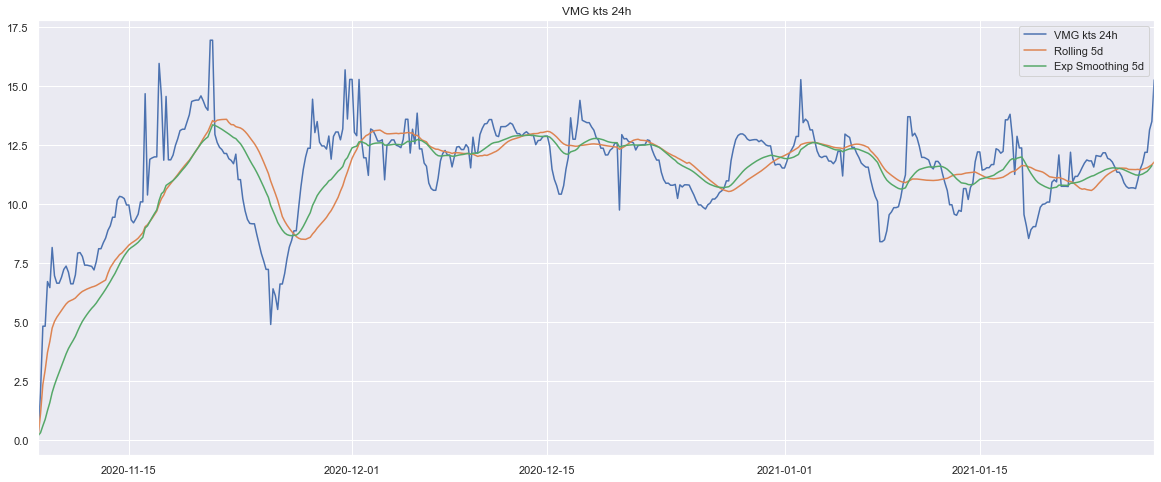

In [45]:
# exp smoothing 5d = 4h * (6h * 5d)
df_vmg_average['Exp Smoothing 5d']=SimpleExpSmoothing(df_vmg_average['VMG kts 24h']) \
                                .fit(smoothing_level=2/(30+1),optimized=False).fittedvalues.shift(-1)

# we plot the results
fig = plt.figure(figsize=(20, 8));
ax = fig.add_subplot(111)
obj = ax.plot(df_vmg_average)
ax.set_title('VMG kts 24h');
plt.legend(iter(obj), ('VMG kts 24h', 'Rolling 5d', 'Exp Smoothing 5d'));
ax.autoscale(axis='x',tight=True);

A l'aide de la fonction ```seasonal_decompose``` de la librairie statsmodels, on peut décomposer la série temporelle en une somme de trois composantes : tendance + seasonalité + résidu que l'on peut afficher. Nous allons travailler sur une période de 24h.

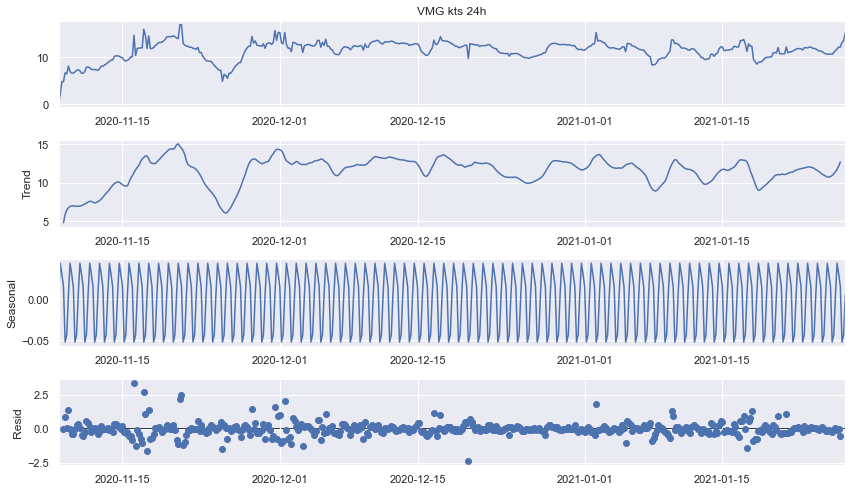

In [35]:
# decomposition with statsmodels
decompo = seasonal_decompose(df_vmg_average['VMG kts 24h'], model='add', period=6)
decompo.plot();

Nous allons entrainer un modèle prédictif SARIMAX. Pour cela dans un premier temps nous découpons notre jeu de données en un jeu train et un jeu test.

In [36]:
# creation of the train and test data sets
df_train = df_vmg_average.iloc[:-100]
df_test = df_vmg_average.iloc[-100:]

Entrainons le modèle et affichons les résultats. les paramètres ```order``` et ```seasonal_order``` sont des paramètres du modèles sur lesquels on peut jouer pour essayer d'améliorer le score.

In [37]:
# create and fit the SARIMAX model
sairmax_mod = SARIMAX(df_train['VMG kts 24h'],order=(0,1,1),seasonal_order=(2,0,0,48))
results = sairmax_mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         VMG kts 24h   No. Observations:                  381
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 48)   Log Likelihood                -457.357
Date:                           sam., 06 nov. 2021   AIC                            922.714
Time:                                     10:19:59   BIC                            938.474
Sample:                                 11-08-2020   HQIC                           928.967
                                      - 01-10-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2584      0.030     -8.687      0.000      -0.317      -0.200
ar.S.L48      -0.0649      0.047     -1.385      0.166      -0.157       0.027
ar.S.L96      -0.1070      0.060     -1.773      0.076      -0.225       0.011
sigma2         0.6477      0.023     28.504      0.000       0.603       0.692
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               991.83
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Maintenant que notre modèle est entrainé nous pouvons faire des prédictions sur le jeu de données test et afficher les vraies données vs les prédictions sur un même graphe.

In [46]:
predictions = results.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False, typ='levels').rename('SARIMA(0,1,1)(2,0,0,12) Predictions')

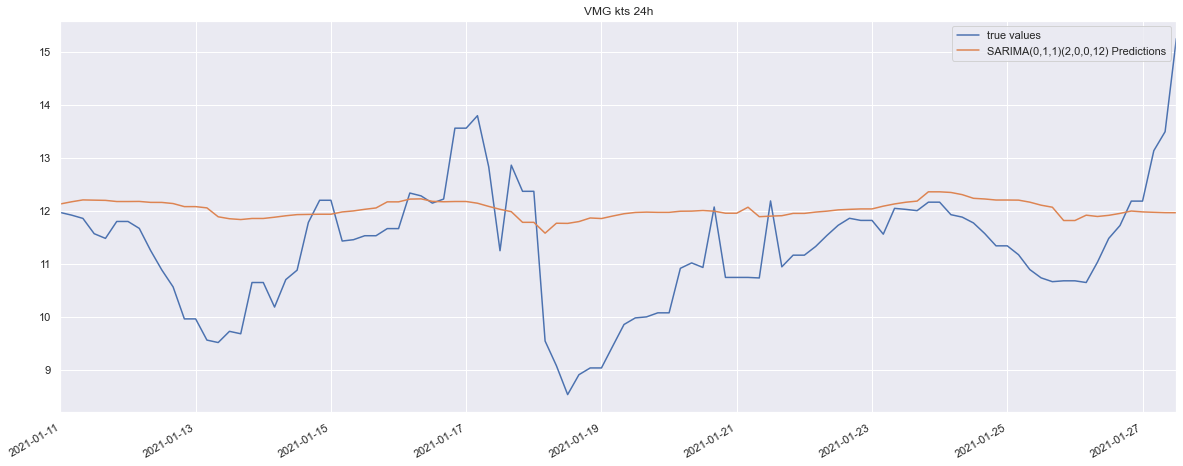

In [39]:
fig = plt.figure(figsize=(20, 8));
ax = fig.add_subplot(111)
ax.plot(df_test['VMG kts 24h'], label='true values')
ax.set_title('VMG kts 24h');
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend();

On constate que notre modèle arrive à prédire la valeur moyenne mais prédit mal les variations à plus hautes fréquence.

## Application d'algorithmes ML

Essayons de faire une classification du types de voilier avec une méthode KMeans. Dans un premier temps nous allons préparer un DataFrame pour cette classification.

Pour cela nous allons utiliser des données numériques, une colonne catégorielle (pour le type de voile quille) et un one hot encoder pour le type de dérive. Certaines des données numériques présentent des NA. Nous allons les remplacer par la meilleur des valeur sur la colonne.

In [40]:
numerical_cols = ['Longueur (m)', 'Largeur (m)', 'Tirant d\'eau (m)', 'Déplacement (poids) (t)', 'Hauteur mât (m)', 'Surface de voiles au près (m2)', 'Surface de voiles au portant (m2)']
df_skippers_classif = df_skippers[[*numerical_cols, 'Voile quille']].copy()

# convert 'Voile quille' into categorical
df_skippers_classif['Voile quille'] = pd.Categorical(df_skippers_classif['Voile quille']).codes #.astype('category')

# convert 'Nombre de dérives' into one hot encoding
df_skippers_classif = df_skippers_classif.join(pd.get_dummies(df_skippers['Nombre de dérives'], prefix='dérive'))

# we fill the na values with the average on the column
df_skippers_classif = df_skippers_classif.apply(lambda x: x.fillna(x.mean()),axis=0)

df_skippers_classif.sample(5)

Longueur (m)  Largeur (m)  Tirant d'eau (m)  Déplacement (poids) (t)  \
27         18.28         5.85               4.5                      8.0   
32         18.28         5.70               4.5                      7.9   
28         18.28         5.70               4.5                      8.0   
6          18.28         5.80               4.5                      7.6   
3          18.28         5.80               4.5                      8.0   

    Hauteur mât (m)  Surface de voiles au près (m2)  \
27             29.0                             320   
32             27.3                             270   
28             29.0                             260   
6              28.0                             300   
3              29.0                             310   

    Surface de voiles au portant (m2)  Voile quille  dérive_2  \
27                                580             3         0   
32                                535            -1         0   
28                                600             1         0   
6                                 600             2         0   
3                                 550             4         0   

    dérive_2 asymétriques  dérive_foils  
27                      0             1  
32                      0             1  
28                      0             1  
6                       0             1  
3                       0             1

Nous allons ensuite normaliser les colonnes numériques

In [41]:
# normalisation avec sklearn :
normalizer = preprocessing.StandardScaler().fit(df_skippers_classif[[*numerical_cols, 'Voile quille']])
df_skippers_classif[[*numerical_cols, 'Voile quille']] = normalizer.transform(df_skippers_classif[[*numerical_cols, 'Voile quille']])

df_skippers_classif.sample(5)

Longueur (m)  Largeur (m)  Tirant d'eau (m)  Déplacement (poids) (t)  \
32           0.0    -0.065279               0.0            -5.009371e-01   
19           0.0    -0.718070               0.0            -9.206412e-01   
26           0.0     0.913908               0.0             7.581751e-01   
24           0.0     1.240303               0.0             3.727721e-15   
2            0.0    -1.109745               0.0             1.807435e+00   

    Hauteur mât (m)  Surface de voiles au près (m2)  \
32        -1.352765                       -1.032094   
19        -1.721701                       -0.035242   
26         0.737872                        1.626178   
24        -1.721701                       -0.367526   
2          0.737872                       -1.364378   

    Surface de voiles au portant (m2)  Voile quille  dérive_2  \
32                          -1.111409     -2.013875         0   
19                           1.305666     -0.599878         0   
26                           0.464945     -0.128545         1   
24                          -0.165597      1.756784         0   
2                           -0.165597     -0.599878         1   

    dérive_2 asymétriques  dérive_foils  
32                      0             1  
19                      0             1  
26                      0             0  
24                      0             1  
2                       0             0

**Méthode du coude :** Nous pouvons maintenant tracer la distortion d'un algorithme KMeans pour plusieurs valeurs de k (= nombre de catégories cherchées). L'idée est que le k optimal se trouve au niveau du coude dans la courbe (point d'inflexion de la courbe).

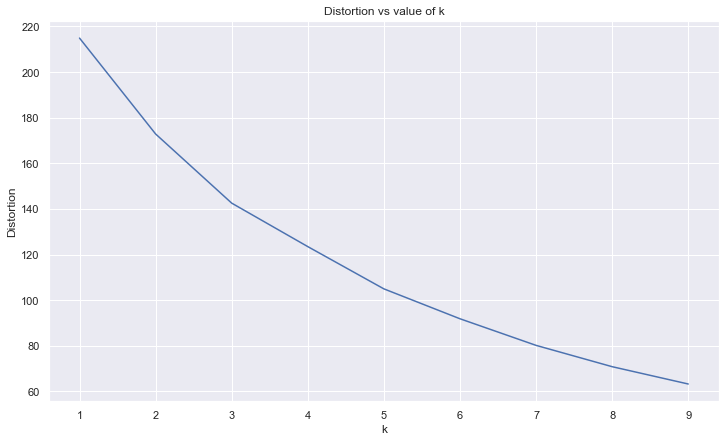

In [42]:
# there is a current issue with KMean classifier the following lines desable the warning
import warnings
warnings.simplefilter('ignore')

# we define a range for k
min_k = 1
max_k = 10
elbow_scores = []

# we loop on the different values of k
for k in range(min_k, max_k):
    # We run k means on each value of k
    kmeans_algo = cluster.KMeans(n_clusters=k)
    kmeans_results = kmeans_algo.fit_transform(df_skippers_classif)
    # We copy dataframe into a new dataframe for results
    df_skippers_classif_results = df_skippers_classif.copy()
    df_skippers_classif_results['labels'] = kmeans_algo.labels_
    
    # We calculate the distortion for each value of k and store it in a list
    elbow_scores.append(kmeans_algo.inertia_)

# We plot the distortions for each value of k
plt.figure(figsize=(12, 7));
plt.plot(list(range(min_k, max_k)), elbow_scores, label='elbow_scores')
plt.xlabel("k");
plt.ylabel("Distortion");
plt.title('Distortion vs value of k');

Il n'y a malheureusement pas de point d'inflexion évident, prenons une valeur de k = 5. Et affichons quel voilier de quel équipage se trouve dans chaque catégorie

In [43]:
kmeans_algo = cluster.KMeans(n_clusters=5)
kmeans_results = kmeans_algo.fit_transform(df_skippers_classif)
df_skippers_classif_results['labels'] = kmeans_algo.labels_

# affichage des résultats
df_skippers_classif_recap = pd.merge(left=df_skippers_classif_results, right=df_skippers,left_index=True, right_index=True)[['Equipage', 'labels']].sort_values('labels')
df_skippers_classif_recap.pivot_table(values='Equipage', index='labels', aggfunc='count')

Equipage
labels          
0              5
1             13
2              6
3              1
4              8

Affichons le nombre de voiliers dans chaque catégorie sous forme d'un piechart

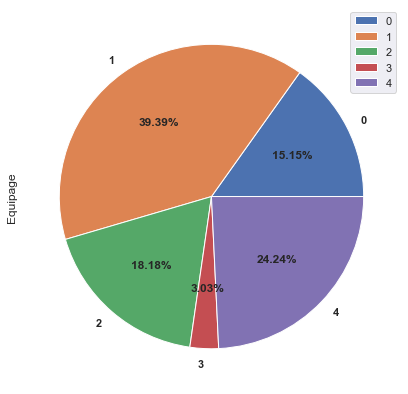

In [44]:
# pie plot
df_skippers_classif_recap.pivot_table(values='Equipage', index='labels', aggfunc='count') \
.plot(kind='pie', y='Equipage', autopct='%1.2f%%', textprops={'weight': 'bold'});
plt.legend();

On se rend compte qu'il y a 1 voire 2 catégories que ne regroupent qu'un ou deux voiliers (les résultats données par KMeans ne sont pas stables et peuvent varier d'une itération à une autre), on aurait pu réduire le nombre de catégories à 3 ou 4.